In [211]:
# 載入基本套件
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [212]:
# 設定 data_path
data_path = 'data/'
train = pd.read_csv(data_path + 'training.csv')
test = pd.read_csv(data_path + 'testing.csv')
ids = test['id']
# 讀取檔案
train.head()

,0,1,2,3,4,5,6,7,8,9,...,10448,10449,10450,10451,10452,10453,10454,10455,10456,10457
0,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,23.465,120.247,17.0
1,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,22.633,120.288,39.0
2,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,22.605,120.308,46.0
3,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,22.758,120.306,31.0
4,1,1,0,23.048,120.218,24.0,25.013,121.459,17.0,25.069,...,33.959,25.156,121.407,9.246,22.587,120.434,21.983,22.689,120.333,33.0


In [213]:
# 拆分成三個一組 
# "0": 月份
# "1": 日期
# "2": 小時
columns=['date','hour','latitude','Longitude','pm2.5']
def refactor_data(origin_data, length):
    refactor_data = pd.DataFrame(columns=columns)
    for i in range(3,length,3) :
        df_temp = origin_data.loc[:,['1','2',str(i) ,str(i+1) ,str(i+2)]]
    # 過濾重複資料
        df_temp.columns = columns
        df_temp = df_temp.drop_duplicates()
        refactor_data = pd.concat([refactor_data,df_temp], ignore_index=True)
    return refactor_data

In [214]:
train_data = refactor_data(train ,len(train.columns))
print(f'訓練資料_1{train_data.shape}')
test_data = refactor_data(test ,len(test.columns) -3 ) # 最後column保留預測
print(f'訓練資料_2{test_data.shape}')
data_info = pd.concat([train_data,test_data], ignore_index=True)
print(f'合併訓練資料{data_info.shape}')
data_info = data_info.drop_duplicates()
print(f'清除重複資料{data_info.shape}')

訓練資料_1(338016, 5)
訓練資料_2(250848, 5)
合併訓練資料(588864, 5)
清除重複資料(588624, 5)


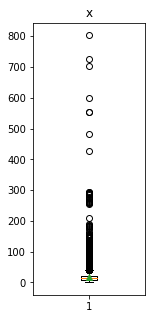

In [215]:
plt.figure(figsize=(2, 5))
plt.boxplot(data_info['pm2.5'], showmeans=True)
plt.title('x')
plt.show()

In [216]:
# 0 低
# 1 中
# 2 高
def get_standard(air):
    if(air <= 35):
        return 1
    elif (air > 35 and air <= 53) : 
        return 2
    elif ( air > 53): 
        return 3

In [217]:
# 大於50的pm2.5離群值刪除
data_info = data_info[data_info['pm2.5'] < 50]

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pm2.5', ylabel='Density'>

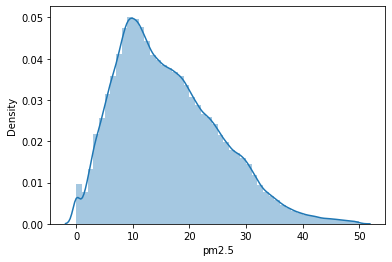

In [218]:
sns.distplot(data_info['pm2.5'])

In [219]:
# 資料轉成int
data_info["date"] = pd.to_numeric(data_info["date"])
data_info["hour"] = pd.to_numeric(data_info["hour"])
data_info.dtypes

date           int64
hour           int64
latitude     float64
Longitude    float64
pm2.5        float64
dtype: object

In [220]:
# 處理要預測資料
predit_data = test.loc[:,['1','2','10455' , '10456']]
predit_data.columns = ['date','hour','latitude','Longitude']
predit_data["date"] = pd.to_numeric(predit_data["date"])
predit_data["hour"] = pd.to_numeric(predit_data["hour"])

In [221]:
# 切分訓練集/測試集
target = data_info['pm2.5']
train_split = data_info.drop(['pm2.5'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(train_split, target, test_size=0.25, random_state=4)

In [222]:
import xgboost as xgb
rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)
gdbt = GradientBoostingRegressor(tol=0.1, subsample=0.37, n_estimators=200, max_features=20,
                                 max_depth=6, learning_rate=0.03)
xgbrModel = xgb.XGBRegressor(learning_rate=0.1,
                             n_estimators=500,
                             max_depth=5,
                             min_child_weight=1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             gamma=0,
                             reg_alpha=0,
                             reg_lambda=1)
# 使用訓練資料訓練模型
gdbt.fit(x_train, y_train)
rf.fit(x_train, y_train)
xgbrModel.fit(x_train, y_train)
# 使用test資料預測
predictedgdbt = gdbt.predict(x_test)
predictedrf = rf.predict(x_test)
predictedxg = xgbrModel.predict(x_test)

In [223]:
print(f'gdbt mse: {mean_squared_error(y_test , predictedgdbt)}')
print(f'rf mse:{mean_squared_error(y_test , predictedrf)}')
print(f'xgb mse:{mean_squared_error(y_test , predictedxg)}')


gdbt mse: 24.16548637639316
rf mse:29.680627891928143
xgb mse:17.764578644392703


In [224]:
feats = pd.Series(data=xgbrModel.feature_importances_, index=x_train.columns)
feats = feats.sort_values(ascending=False)
feats


latitude     0.380399
Longitude    0.318059
date         0.205978
hour         0.095564
dtype: float32

In [225]:
# loss = ['ls', 'lad', 'huber']
# n_estimators = [300, 500, 600, 800]
# max_depth = [2, 3, 5, 10, 15]
# min_samples_leaf = [ 6, 8 , 10] 
# min_samples_split = [2, 4, 6, 10]
# max_features = ['auto', 'sqrt', 'log2', None]

# # Define the grid of hyperparameters to search
# hyperparameter_grid = {'loss': loss,
#     'n_estimators': n_estimators,
#     'max_depth': max_depth,
#     'min_samples_leaf': min_samples_leaf,
#     'min_samples_split': min_samples_split,
#     'max_features': max_features}

# # Set up the random search with 4-fold cross validation
# random_cv = RandomizedSearchCV(estimator=gradientboost,
#             param_distributions=hyperparameter_grid,
#             cv=4, n_iter=50,
#             scoring = 'neg_mean_absolute_error',
#             verbose = 5, 
#             random_state=42)
# random_cv.fit(x_train,y_train)

# print(random_cv.best_estimator_)
# print(random_cv.best_score_)

In [226]:
# sub = pd.DataFrame({"id":ids , "pm2.5" :predictedgdbt})
# sub.to_csv("728gdbt.csv" , index=False)

In [227]:
# from ctypes.wintypes import tagRECT
import xgboost as xgb

# # 建立 XGBRegressor 模型
# cv_params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'min_child_weight': [1, 2, 3, 4, 5, 6]}
# other_params = {'learning_rate': 0.07, 'n_estimators': 650, 'max_depth': 7, 'min_child_weight': 6, 'seed': 0,
#                     'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 3, 'reg_lambda': 1}
# other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
#  'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
# xgbrModel = xgb.XGBRegressor(**other_params)
# # 使用訓練資料訓練模型
# xgbrModel.fit(x_train, y_train)
# # 使用test資料預測
# predicted=xgbrModel.predict(x_test)

# sub = pd.DataFrame({'id': ids, 'pm2.5': np.round(predicted)})
# sub.to_csv('727.csv', index=False) 

# optimized_GBM = GridSearchCV(estimator=xgbrModel, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
# optimized_GBM.fit(x_train, y_train)
# evalute_result = optimized_GBM.cv_results_
# print('每輪结果:{0}'.format(evalute_result))
# print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
# print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

In [228]:
# print(f'xgb mse:{mean_squared_error(y_test , predictedxg)}')
feats = pd.Series(data=xgbrModel.feature_importances_,
                  index=train_split.columns)
feats = feats.sort_values(ascending=False)
feats


latitude     0.380399
Longitude    0.318059
date         0.205978
hour         0.095564
dtype: float32

In [229]:
# sub = pd.DataFrame({"id": ids, "pm2.5": predictedxg})
# sub.to_csv("730xgb.csv" , index=False)
